# Data Trial Clever - André Pegoraro Neto

In [50]:
pip install pandas psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
import psycopg2 as pg

engine = pg.connect("dbname='clever' user='clever' host='postgres_clever' port='5432' password='clever'")

## Introduction

The process I used for solving this data trial was running all the queries in pgAdmin before documenting the final queries here. This allowed me to visualize and validate data formats, categories inside columns and keys for joining tables. After that, I happened to have insights by giving a look at the data and exploring in a bit deeper.

## Data Loading

But, before the transformation process, there was the process using Airflow to orchestrate the data loading into Postgres. The first problem encountered was helping the csv reader understand how and where to consider the delimiters. This included **commas**, **double quotes** and especially **escaped quotes**.

After writing and rewriting the cleaning functions, it finally worked the way I wanted and I could load them up into the database. At the end, it was simpler than it seemed.

## Google Maps Company Profiles Data

The first thing to do was to explore and try to understand the data, finding patters and associations that led me to do what I thought were the right transformations.

#### This table provides information about Company Profiles in the Real Estate market for three of the biggest cities in the United States:
- Miami, FL
- Dallas, TX
- Seattle, WA

The table includes the Company Name, the types and subtypes of Realtors and Real State Agencies and other specific characteristics.

#### Here I performed a series of transformations that included:
- Renamings
- Casts
- Character replacements
- Condition clauses creation
- `.json` extracts

In [52]:
company_profiles = pd.read_sql(
    """
    with sourcing as (
    	select
    		google_id
    		, name as company_name
    		, site as company_website
    		, type
    		, subtypes
    		, category
    		, phone
    		, full_address
    		, borough
    		, street
    		, city
    		, postal_code
    		, state
    		, country
    		, country_code
    		, latitude::float as latitude
    		, longitude::float as longitude
    		, time_zone
    		, plus_code -- google maps address for people that don't have one
    		, area_service
    		, rating::numeric(10, 1) as rating
    		, reviews_link
    		, reviews_tags
    		, photo
    		, photos_count -- review the necessity of this info
    		, street_view
    		, located_in
    		, regexp_replace(regexp_replace(working_hours, '\\\\', '', 'g'), '&&', '"', 'g') as working_hours
    		, popular_times -- mostly null values
    		, case
    			when business_status = 'CLOSED_PERMANENTLY'
    				then 'Closed Permanently'
    			when business_status = 'CLOSED_TEMPORARILY'
    				then 'Closed Temporarily'
    			when business_status = 'OPERATIONAL'
    				then 'Operational'
    			else null
    		end as business_status
    		, regexp_replace(regexp_replace(about, '\\\\', '', 'g'), '&&', '"', 'g') as about
    		, range -- mostly null
    		-- , posts -- mostly null
    		, logo
    		, description -- mostly null
    		, typical_time_spent -- mostly_null
    		, verified::boolean as verified
    		, owner_id::varchar as owner_id
    		, owner_title
    		, owner_link
    		, reservation_links
    		, booking_appointment_link
    		, menu_link
    		, order_links
    		, location_link
    		, place_id
    		, cid::varchar as cid
    		, reviews_id::varchar as reviews_id
    		, located_google_id -- mostly null
    		, reviews::int
    	from public.company_profiles_escaped
    )
    , extracting_json as ( 
    	select
            google_id
    		, company_name
    		, company_website
    		, type
    		, subtypes
    		, category
    		, phone
    		, full_address
    		, borough
    		, street
    		, city
            , case
    			when city = 'Dallas'
    				then 'Texas'
    			when city = 'Miami'
    				then 'Florida'
    			when city = 'Seattle'
    				then 'Washington'
    		end as state
    		, postal_code
    		, country
    		, country_code
    		, latitude
    		, longitude
    		, time_zone
    		, plus_code
    		, area_service
    		, rating
            , reviews
    		, reviews_link
    		, reviews_tags
    		, photo
    		, photos_count
    		, street_view
    		, located_in
    		/* Working Hours */
    		, coalesce(regexp_replace(cast(working_hours::json->'Sunday' as varchar), '"', '', 'g'), 'Not informed') as sunday_working_hours
    		, coalesce(regexp_replace(cast(working_hours::json->'Monday' as varchar), '"', '', 'g'), 'Not informed') as monday_working_hours
            , coalesce(regexp_replace(cast(working_hours::json->'Tuesday' as varchar), '"', '', 'g'), 'Not informed') as tuesday_working_hours
            , coalesce(regexp_replace(cast(working_hours::json->'Wednesday' as varchar), '"', '', 'g'), 'Not informed') as wednesday_working_hours
            , coalesce(regexp_replace(cast(working_hours::json->'Thursday' as varchar), '"', '', 'g'), 'Not informed') as thursday_working_hours
            , coalesce(regexp_replace(cast(working_hours::json->'Friday' as varchar), '"', '', 'g'), 'Not informed') as friday_working_hours
            , coalesce(regexp_replace(cast(working_hours::json->'Saturday' as varchar), '"', '', 'g'), 'Not informed') as saturday_working_hours
    		, popular_times
    		, business_status
    		/* Sefice Options */
    		, coalesce(about::json->'Service options'->>'Curbside pickup', 'false')::boolean as curbside_pickup
            , coalesce(about::json->'Service options'->>'Delivery', 'false')::boolean as delivery
            , coalesce(about::json->'Service options'->>'Dine-in', 'false')::boolean as dine_in
            , coalesce(about::json->'Service options'->>'In-store pickup', 'false')::boolean as in_store_pickup
            , coalesce(about::json->'Service options'->>'In-store shopping', 'false')::boolean as in_store_shopping
    		, coalesce(about::json->'Service options'->>'Language assistance', 'No') AS language_assistance
            , coalesce(about::json->'Service options'->>'No-contact delivery', 'false')::boolean as no_contact_delivery
            , coalesce(about::json->'Service options'->>'Online appointments', 'false')::boolean as online_appointments
            , coalesce(about::json->'Service options'->>'Online classes', 'false')::boolean as online_classes
            , coalesce(about::json->'Service options'->>'Online estimates', 'false')::boolean as online_estimates
            , coalesce(about::json->'Service options'->>'Onsite services', 'false')::boolean as onsite_services
            , coalesce(about::json->'Service options'->>'Same-day delivery', 'false')::boolean as same_day_delivery
            , coalesce(about::json->'Service options'->>'Takeout', 'false')::boolean as takeout
    		/* Accessibility */
            , coalesce(about::json->'Accessibility'->>'Wheelchair accessible elevator', 'false')::boolean as wheelchair_accessible_elevator
            , coalesce(about::json->'Accessibility'->>'Wheelchair accessible entrance', 'false')::boolean as wheelchair_accessible_entrance
            , coalesce(about::json->'Accessibility'->>'Wheelchair accessible parking lot', 'false')::boolean as wheelchair_accessible_parking_lot
            , coalesce(about::json->'Accessibility'->>'Wheelchair accessible restroom', 'false')::boolean as wheelchair_accessible_restroom
            , coalesce(about::json->'Accessibility'->>'Wheelchair accessible seating', 'false')::boolean as wheelchair_accessible_seating
            /* From the business */
    		, coalesce(about::json->'From the business'->>'Identifies as Asian-owned', 'false')::boolean as identifies_as_asian_owned
            , coalesce(about::json->'From the business'->>'Identifies as Black-owned', 'false')::boolean as identifies_as_black_owned
            , coalesce(about::json->'From the business'->>'Identifies as Indigenous-owned', 'false')::boolean as identifies_as_indigenous_owned
            , coalesce(about::json->'From the business'->>'Identifies as LGBTQ+ owned', 'false')::boolean as identifies_as_lgbtq_owned
            , coalesce(about::json->'From the business'->>'Identifies as Latino-owned', 'false')::boolean as identifies_as_latino_owned
            , coalesce(about::json->'From the business'->>'Identifies as disabled-owned', 'false')::boolean as identifies_as_disabled_owned
            , coalesce(about::json->'From the business'->>'Identifies as veteran-owned', 'false')::boolean as identifies_as_veteran_owned
            , coalesce(about::json->'From the business'->>'Identifies as women-owned', 'false')::boolean as identifies_as_women_owned
            , coalesce(about::json->'From the business'->>'Small business', 'false')::boolean as small_business
            /* Crowd */
    		, coalesce(about::json->'Crowd'->>'Groups', 'false')::boolean as groups
            , coalesce(about::json->'Crowd'->>'LGBTQ+ friendly', 'false')::boolean as lgbtq_friendly
            , coalesce(about::json->'Crowd'->>'Tourists', 'false')::boolean as tourists
            , coalesce(about::json->'Crowd'->>'Transgender safespace', 'false')::boolean as transgender_safespace
            /* Meeting Planning */
    		, coalesce(about::json->'Planning'->>'Accepts reservations', 'false')::boolean as accepts_reservations
            , coalesce(about::json->'Planning'->>'Appointment required', 'false')::boolean as appointment_required
            , coalesce(about::json->'Planning'->>'Appointments recommended', 'false')::boolean as appointments_recommended
            , coalesce(about::json->'Planning'->>'Quick visit', 'false')::boolean as quick_visit
            /* Payment Methods */
    		, coalesce(about::json->'Payments'->>'Checks', 'false')::boolean as payments_checks
            , coalesce(about::json->'Payments'->>'Credit cards', 'false')::boolean as payments_credit_cards
            , coalesce(about::json->'Payments'->>'Debit cards', 'false')::boolean as payments_debit_cards
            , coalesce(about::json->'Payments'->>'NFC mobile payments', 'false')::boolean as payments_nfc_mobile
            , coalesce(about::json->'Payments'->>'SNAP/EBT', 'false')::boolean as payments_snap_ebt
    		, logo
    		, description -- mostly null
    		, typical_time_spent -- mostly_null
    		, verified
    		, owner_id
    		, owner_title
    		, owner_link
    		, reservation_links
    		, booking_appointment_link
    		, menu_link
    		, order_links
    		, location_link
    		, place_id
    		, cid
    	from sourcing
    )
    select *
    from extracting_json
    """
    , con=engine)
print(company_profiles)

/tmp/ipykernel_159/92807712.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  company_profiles = pd.read_sql(


                                  google_id  \
0      0x111f53bf849f031:0xb43eff4f62923c5d   
1      0x14e179155727173b:0x2c342e5f13a9b2d   
2     0x14e4b9f6c46524a9:0x202749ab2be6bfe3   
3       0x1803389f251373:0x26e9e6cc7312627c   
4      0x18751cf7cb7e9a5:0xad85fc0dfe9ff490   
...                                     ...   
5860   0xf47e881c9994e7b:0x2182515d23ed2346   
5861  0x88d9b526dc1dde15:0xf1a594977f12ec6c   
5862   0xcd01879723234e5:0x3ea7f9f4c8a4adb7   
5863  0x864e9965507a75ff:0xf3b4cbcb39e97acf   
5864   0xdd29bbfc28930ed:0x2f32238a396b70bf   

                                    company_name  \
0                            Nicolas Boucher P.A   
1                                New Hope Realty   
2                     Harvey Mclean & Associates   
3                             Yanet Mino Realtor   
4     Lunabase Travelstays & Property Management   
...                                          ...   
5860                          Gianfran Fernandez   
5861               

In [53]:
company_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 91 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   google_id                          5865 non-null   object 
 1   company_name                       5865 non-null   object 
 2   company_website                    4499 non-null   object 
 3   type                               5858 non-null   object 
 4   subtypes                           5858 non-null   object 
 5   category                           5858 non-null   object 
 6   phone                              5622 non-null   object 
 7   full_address                       5865 non-null   object 
 8   borough                            3823 non-null   object 
 9   street                             5845 non-null   object 
 10  city                               5865 non-null   object 
 11  state                              5865 non-null   objec

#### Visualizing some columns to see if the transformations worked properly, especially the json extract ones.

In [54]:
company_profiles[['company_name', 'monday_working_hours', 'wheelchair_accessible_entrance']].head(10)

,company_name,monday_working_hours,wheelchair_accessible_entrance
0,Nicolas Boucher P.A,9AM-8PM,True
1,New Hope Realty,9AM-5PM,False
2,Harvey Mclean & Associates,Not informed,False
3,Yanet Mino Realtor,Open 24 hours,True
4,Lunabase Travelstays & Property Management,Open 24 hours,True
5,"Nathalie Alfonso, Realtor",Open 24 hours,True
6,Patricia Robinson,9AM-9PM,True
7,Jose Luis Guilarte - Miami Realtor,Open 24 hours,True
8,"Hector Rios, PA | Realtor",9AM-9PM,True
9,Trace Real Estate Services,Not informed,True


With this table, it is possible to sort the data based on specific preferences by the client. For example, if the client wants to buy a property with a realtor located in Miami but can only meet him in person on a Tuesday 11PM.

### Filtering by City and Working Hours

In [55]:
company_profiles_filtered_tuesday = company_profiles.query(
    'city == "Miami" and tuesday_working_hours == "Open 24 hours"'
)[['company_name', 'tuesday_working_hours', 'city']]
company_profiles_filtered_tuesday.head(10)

,company_name,tuesday_working_hours,city
3,Yanet Mino Realtor,Open 24 hours,Miami
4,Lunabase Travelstays & Property Management,Open 24 hours,Miami
5,"Nathalie Alfonso, Realtor",Open 24 hours,Miami
7,Jose Luis Guilarte - Miami Realtor,Open 24 hours,Miami
11,"Jonathan Gonzalez, Miami Realtor",Open 24 hours,Miami
12,Luis Perez - Realtor Miami Florida,Open 24 hours,Miami
15,Alexandria Realty Group,Open 24 hours,Miami
34,"Gladys C Nardon Azua PA, Realtor",Open 24 hours,Miami
52,The Edit - Luxury Real Estate Brokerage,Open 24 hours,Miami
54,Florida Ocean Home,Open 24 hours,Miami


These are 10 options we can give out client to look for. But let's be more specific. Lets suppose we're looking for the ones located in West End Miami and rank them by google rating reviews:

### Filtering by Rating

In [56]:
company_profiles_filtered_rating = company_profiles.query(
    'city == "Miami" and borough == "West End" and tuesday_working_hours == "Open 24 hours"'
)[['company_name', 'tuesday_working_hours', 'city', 'state', 'borough', 'rating']]
company_profiles_filtered_rating.sort_values(by='rating', ascending=False).head(10)

,company_name,tuesday_working_hours,city,state,borough,rating
4923,Lisandra Castro PA,Open 24 hours,Miami,Florida,West End,5.0
4913,"D’Havana Estates Group, LLC:Yaima cartaya",Open 24 hours,Miami,Florida,West End,5.0
4928,Labrada Realty,Open 24 hours,Miami,Florida,West End,5.0
4936,Tatiana Suarez - Realtor,Open 24 hours,Miami,Florida,West End,5.0
5005,Miami Realtor Marlon Cadenas,Open 24 hours,Miami,Florida,West End,5.0
5008,"Gloria Neves, Real Estate Specialist",Open 24 hours,Miami,Florida,West End,5.0
5036,Yeramy Aneiro P.A.,Open 24 hours,Miami,Florida,West End,5.0
5039,Nicolas_Anyela_Realestate Compass Realty Group,Open 24 hours,Miami,Florida,West End,5.0
5096,Margend Palacios P.A.,Open 24 hours,Miami,Florida,West End,5.0
5151,"Rosa Galarreta, Monteriny Properties Corporation",Open 24 hours,Miami,Florida,West End,5.0


We can see that there are preety well rated realtors in West End Miami. Let's now say that out client wants only the ones with wheelchair acessible entrance:

### Filtering by Acess for Disabled People

In [57]:
company_profiles_filtered_wheelchair = company_profiles.query(
    'city == "Miami" and borough == "West End" and tuesday_working_hours == "Open 24 hours" and wheelchair_accessible_entrance == True'
)[['company_name', 'tuesday_working_hours', 'city', 'state', 'borough', 'rating']]
company_profiles_filtered_wheelchair.sort_values(by='rating', ascending=False).head(10)

,company_name,tuesday_working_hours,city,state,borough,rating
4923,Lisandra Castro PA,Open 24 hours,Miami,Florida,West End,5.0
2831,"Dylan Fils-aime, Realtor",Open 24 hours,Miami,Florida,West End,5.0
4936,Tatiana Suarez - Realtor,Open 24 hours,Miami,Florida,West End,5.0
5005,Miami Realtor Marlon Cadenas,Open 24 hours,Miami,Florida,West End,5.0
5008,"Gloria Neves, Real Estate Specialist",Open 24 hours,Miami,Florida,West End,5.0
5036,Yeramy Aneiro P.A.,Open 24 hours,Miami,Florida,West End,5.0
5039,Nicolas_Anyela_Realestate Compass Realty Group,Open 24 hours,Miami,Florida,West End,5.0
5096,Margend Palacios P.A.,Open 24 hours,Miami,Florida,West End,5.0
5151,"Rosa Galarreta, Monteriny Properties Corporation",Open 24 hours,Miami,Florida,West End,5.0
5152,Liberty TaxCrafters LLC,Open 24 hours,Miami,Florida,West End,5.0


### Filtering by Rating and Most Reviews

Going even further, let's say now that the client wants to choose between the ones with best rating and most reviews:

In [58]:
company_profiles_filtered_reviews = company_profiles.query(
    'city == "Miami" and borough == "West End" and tuesday_working_hours == "Open 24 hours" and wheelchair_accessible_entrance == True'
)[['company_name', 'tuesday_working_hours', 'city', 'state', 'borough', 'rating', 'reviews']]
company_profiles_filtered_reviews.sort_values(by=['rating', 'reviews'], ascending=False).head(10)

,company_name,tuesday_working_hours,city,state,borough,rating,reviews
4718,Elite Real Estate Associates,Open 24 hours,Miami,Florida,West End,5.0,118.0
5152,Liberty TaxCrafters LLC,Open 24 hours,Miami,Florida,West End,5.0,102.0
5096,Margend Palacios P.A.,Open 24 hours,Miami,Florida,West End,5.0,97.0
5005,Miami Realtor Marlon Cadenas,Open 24 hours,Miami,Florida,West End,5.0,40.0
5008,"Gloria Neves, Real Estate Specialist",Open 24 hours,Miami,Florida,West End,5.0,37.0
5039,Nicolas_Anyela_Realestate Compass Realty Group,Open 24 hours,Miami,Florida,West End,5.0,34.0
4936,Tatiana Suarez - Realtor,Open 24 hours,Miami,Florida,West End,5.0,24.0
4668,Nancy Katherine Ginart,Open 24 hours,Miami,Florida,West End,5.0,17.0
4859,Alicia E Gomez REALTOR,Open 24 hours,Miami,Florida,West End,5.0,17.0
4557,"Dominick Martinez - Pronto Realty, LLC.",Open 24 hours,Miami,Florida,West End,5.0,16.0


## Customer Reviews Data

This table's contains reviews from clients to real estate agents (the ones described in the the last table). The granularity is the review_id, but it has also the google_id, which allows us to join it with company_profiles.

The table provides geral information like the Companies' Names, the rating of each review, the text from the author and the response from the owner (the realtor).

In [59]:
customer_reviews = pd.read_sql(
    """
    with customer_reviews as (
    	select *
    	from public.customer_reviews_escaped_filtered
    )
    , company_profiles as (
    	select
    		google_id
    		, city
    		, case
    			when city = 'Dallas'
    				then 'Texas'
    			when city = 'Miami'
    				then 'Florida'
    			when city = 'Seattle'
    				then 'Washington'
    		end as state
    		, borough
    	from public.company_profiles_escaped
    )
    , joining as (
    	select
    		customer_reviews.google_id
    		, customer_reviews.review_id
    		, customer_reviews.name as company_name
    		, customer_reviews.place_id
    		, customer_reviews.reviews
    		, customer_reviews.review_rating
    		, customer_reviews.review_datetime_utc::timestamp
    		, customer_reviews.review_pagination_id
    		, customer_reviews.author_title
    		, customer_reviews.author_id::varchar
    		, company_profiles.city
    		, company_profiles.borough
    		, company_profiles.state
    		, customer_reviews.author_reviews_count::int
    		, customer_reviews.review_text
    	 	, customer_reviews.owner_answer
    		, customer_reviews.owner_answer_timestamp_datetime_utc::timestamp as owner_anwer_timestamp
    		
    		/* urls */
    		, customer_reviews.location_link
    		, customer_reviews.reviews_link
    		, customer_reviews.author_link
    		, customer_reviews.review_img_url
    		, customer_reviews.review_img_urls
    		, customer_reviews.review_link
    	from customer_reviews
    	inner join company_profiles
    		on company_profiles.google_id = customer_reviews.google_id
    )
    select *
    from joining
    """
    , con=engine)
customer_reviews.head(5)

/tmp/ipykernel_159/1851186844.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_reviews = pd.read_sql(


,google_id,review_id,company_name,place_id,reviews,review_rating,review_datetime_utc,review_pagination_id,author_title,author_id,...,author_reviews_count,review_text,owner_answer,owner_anwer_timestamp,location_link,reviews_link,author_link,review_img_url,review_img_urls,review_link
0,0x864c26c8a3f9fe6f:0x9f5f2eee19038a8b,ChZDSUhNMG9nS0VJQ0FnSUNabHRtNEZREAE,Wildcat Movers - Dallas,ChIJb_75o8gmTIYRi4oDGe4uX58,1692.0,5.0,2023-09-09 22:50:00,CAESBkVnSUliZw==,Savannah Jackson,1.18029e+20,...,5.0,We had an amazing experience with Wildcat Move...,None,NaT,https://www.google.com/maps/place/Wildcat+Move...,https://search.google.com/local/reviews?placei...,https://www.google.com/maps/contrib/1180290970...,https://lh5.googleusercontent.com/p/AF1QipNLYp...,https://lh5.googleusercontent.com/p/AF1QipNLYp...,https://www.google.com/maps/reviews/data=!4m8!...
1,0x864e99d71a97da87:0xacad6516b3a8297,ChdDSUhNMG9nS0VJQ0FnSUNabHBhZGtBRRAB,AB Moving,ChIJh9qXGteZToYRl4I6a1HWygo,724.0,5.0,2023-09-09 22:00:00,CAESB0VnTUl0UUU=,elizabeth adetiba,1.10308e+20,...,0.0,"The company was very responsive, and the mover...",None,NaT,https://www.google.com/maps/place/AB+Moving/@3...,https://search.google.com/local/reviews?placei...,https://www.google.com/maps/contrib/1103082439...,None,None,https://www.google.com/maps/reviews/data=!4m8!...
2,0x864c26c8a3f9fe6f:0x9f5f2eee19038a8b,ChZDSUhNMG9nS0VJQ0FnSUNaNXVfUVF3EAE,Wildcat Movers - Dallas,ChIJb_75o8gmTIYRi4oDGe4uX58,1692.0,5.0,2023-09-09 20:36:00,CAESBkVnSUlidw==,Kathryn Conrad,1.05376e+20,...,1.0,Demarcus and Vincent were absolutely AMAZING! ...,None,NaT,https://www.google.com/maps/place/Wildcat+Move...,https://search.google.com/local/reviews?placei...,https://www.google.com/maps/contrib/1053763761...,https://lh5.googleusercontent.com/p/AF1QipOIHe...,https://lh5.googleusercontent.com/p/AF1QipOIHe...,https://www.google.com/maps/reviews/data=!4m8!...
3,0x549015ed168dab6d:0x301820ce37c9de5b,ChdDSUhNMG9nS0VJQ0FnSUNaNXRQRnZnRRAB,Pure Moving Company Seattle Movers Local & Lon...,ChIJbauNFu0VkFQRW97JN84gGDA,597.0,5.0,2023-09-09 20:05:00,CAESB0VnTUl1QUU=,Shane Christopherson,1.05578e+20,...,2.0,Andy and his team did a great job getting us m...,None,NaT,https://www.google.com/maps/place/Pure+Moving+...,https://search.google.com/local/reviews?placei...,https://www.google.com/maps/contrib/1055784996...,https://lh5.googleusercontent.com/p/AF1QipOv4l...,https://lh5.googleusercontent.com/p/AF1QipOv4l...,https://www.google.com/maps/reviews/data=!4m8!...
4,0x549015ed168dab6d:0x301820ce37c9de5b,ChZDSUhNMG9nS0VJQ0FnSUNaNXJTaE93EAE,Pure Moving Company Seattle Movers Local & Lon...,ChIJbauNFu0VkFQRW97JN84gGDA,597.0,5.0,2023-09-09 18:07:00,CAESB0VnTUl1UUU=,Kevin Sorensen,1.12121e+20,...,2.0,"Extremely efficient, great communication, and ...",None,NaT,https://www.google.com/maps/place/Pure+Moving+...,https://search.google.com/local/reviews?placei...,https://www.google.com/maps/contrib/1121212537...,https://lh5.googleusercontent.com/p/AF1QipOYup...,https://lh5.googleusercontent.com/p/AF1QipOYup...,https://www.google.com/maps/reviews/data=!4m8!...


In [60]:
customer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12039 entries, 0 to 12038
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   google_id              12039 non-null  object        
 1   review_id              12039 non-null  object        
 2   company_name           12039 non-null  object        
 3   place_id               12039 non-null  object        
 4   reviews                12039 non-null  float64       
 5   review_rating          12039 non-null  float64       
 6   review_datetime_utc    12039 non-null  datetime64[ns]
 7   review_pagination_id   11959 non-null  object        
 8   author_title           12029 non-null  object        
 9   author_id              12039 non-null  object        
 10  city                   12039 non-null  object        
 11  borough                7753 non-null   object        
 12  state                  12039 non-null  object        
 13  a

### Filtering by City

Now let's see the other side of the coin. Instead of looking for the best ratings, let's look for the worst. Suppose we want to filter the reviews for Dallas, looking for the companies with the worst average review_rating in the city:

In [61]:
customer_reviews_city = customer_reviews.query(
    'city == "Dallas"'
)[['review_id', 'company_name', 'city', 'review_rating']]
company_avg_reviews = customer_reviews_city.groupby(['company_name', 'city']).agg(
    avg_review_rating=('review_rating', 'mean')
).reset_index()

company_avg_reviews.sort_values(by='avg_review_rating', ascending=True).head(10)

,company_name,city,avg_review_rating
19,RAIN Realty,Dallas,3.000000
22,We Buy Ugly Houses and HomeVestors,Dallas,3.285714
8,Dallas Home Buyers,Dallas,4.250000
10,DeWitt & DeWitt,Dallas,4.296296
2,AM Moving Company,Dallas,4.366359
1,AB Moving,Dallas,4.545580
25,investorade,Dallas,4.596774
12,Exodus Moving & Storage LLC,Dallas,4.615942
15,LUSH Property Solutions ️,Dallas,4.636364
9,Dallas Luxury Realty,Dallas,4.696970


Based on these results, we can identify the real estate companies that we should avoid recommending to our clients.

### Filtering by City and Year

Sometimes, data can be misleading when we're calculating mathematical operations like the average value of a group. In this case, we calulated the average considering years of reviews. Although, when we take just the last year, for example, we find different results:

In [62]:
# customer_reviews['review_datetime_utc'] = pd.to_datetime(customer_reviews['review_datetime_utc'])
customer_reviews_2023 = customer_reviews[customer_reviews['review_datetime_utc'].dt.year == 2023].query(
    'city == "Dallas"'
)
company_avg_reviews_2023 = customer_reviews_2023.groupby(['company_name', 'city']).agg(
    avg_review_rating=('review_rating', 'mean')
).reset_index()

company_avg_reviews_2023.sort_values(by='avg_review_rating', ascending=True).head(10)


,company_name,city,avg_review_rating
17,We Buy Ugly Houses and HomeVestors,Dallas,3.400000
9,Exodus Moving & Storage LLC,Dallas,3.400000
20,investorade,Dallas,3.666667
1,AB Moving,Dallas,4.318408
15,REAL Dallas Properties and Management,Dallas,4.444444
8,Dallas Luxury Realty,Dallas,4.500000
18,Wildcat Movers - Dallas,Dallas,4.702532
2,AM Moving Company,Dallas,4.709677
19,Wrightway Moving Company LLC,Dallas,4.777778
12,Phoenix Express Specialty Moving & Delivery,Dallas,4.842105


Companies like "RAIN Realty" and "LUSH Property Solutions" got out of the list, meaning that they're probably providing a better service right now.

## FMCSA Data

The first step was to explore the FMCSA data. By doing this, I found that fmcsa_companies, fmcsa_company_snapshot and fmcsa_safer_data have the same grain, which is the company (usdot_num) itself. The three datasets have similar information, ones having the same columns and others having more columns than others.

This was enought to realise they can be joined in only one column to make it easier to dispose the information to the client. By doing the query below, it's possible to understand if the keys (later PK and FKs) join correctly and also show which usdot_nums are missing in the safer_data dataset

In [63]:
fmcsa_data = pd.read_sql(
    """
    select
    	fmcsa_companies.usdot_num
    	, fmcsa_company_snapshot.usdot_num
    	, fmcsa_safer_data.usdot_num
    from public.fmcsa_companies
    left join public.fmcsa_company_snapshot
    	on fmcsa_companies.usdot_num = fmcsa_company_snapshot.usdot_num
    left join public.fmcsa_safer_data
    	on fmcsa_companies.usdot_num = fmcsa_safer_data.usdot_num
    where fmcsa_companies.usdot_num is null
    	or fmcsa_company_snapshot.usdot_num is null
    	or fmcsa_safer_data.usdot_num is null
    """
, con=engine)
print(fmcsa_data)

  usdot_num usdot_num usdot_num
0   3035106   3035106      None
1   3535426   3535426      None
2   3148696   3148696      None
3   3661270   3661270      None
4   3166409   3166409      None
5   3722904   3722904      None


/tmp/ipykernel_159/2846959786.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fmcsa_data = pd.read_sql(


With this I could write the staging layers to later join them in a fact_fmcsa_companies. I decided to consider it a fact table because it has quantitative information about the companies and, by definition, those are facts.

## FMCSA Companies

In [64]:
fmcsa_companies = pd.read_sql(
    """
    with companies as (
    	select
    		usdot_num
    		, user_created
    		, date_created
    		, user_updated
    		, date_updated
    		, company_name
    		, company_url
    		, city
    		, state
    		, location
    		, company_type
    		, total_complaints_2021
    		, total_complaints_2022
    		, total_complaints_2023
    	from public.fmcsa_companies
    )
    , company_snapshot as (
    	select
    		usdot_num
    		, fmsca_ai_profile as fmcsa_ai_profile
    		, user_created
    		, date_created
    		, user_updated
    		, date_updated
    		, company_name
    		, mc_num
    		, registered_address
    		, case
    			when mailing_address = 'Same as above'
    				then registered_address
    			else mailing_address
    		end as mailing_address
    		, phone_number
    		, fax_number
    		, safety_review_date
    		, num_of_trucks as number_of_trucks
    		, num_of_tractors as number_of_tractors
    		, num_of_trailers as number_of_trailers
    		, hhg_authorization
    		, total_complaints_2021
    		, total_complaints_2022
    		, total_complaints_2023
    	from public.fmcsa_company_snapshot
    )
    , safer_data as (
    	select
    	    usdot_num
    		, fmcsa_link
    		, user_created
    		, date_created
    		, user_updated
    		, date_updated
    		, entity_type
    		, operating_status
    		, oos_date
    		, legal_name
    		, dba_name
    		, physical_address
    		, phone
    		, mailing_address
    		-- , state_carrier_id_number -- null
    		, mc_num
    		, duns_number
    		, power_units
    		, coalesce(drivers, 0) as total_drivers
    		, mcs_150_form_date -- form
    		, operation_classification
    		, carrier_type
    	    , case
    	        when cargo_types like '%General Freight%'
    	            then 'True'
    	        else 'False'
    	    end as general_freight_transport
    	    , case
    	        when cargo_types like '%Household Goods%'
    	            then 'True'
    	        else 'False'
    	    end as household_goods_transport
    	    , case
    	        when cargo_types like '%Furniture%'
    	            then 'True'
    	        else 'False'
    	    end as furniture_transport
    		, case
    	        when cargo_types like '%FINE ART%'
    	            then 'True'
    	        else 'False'
    	    end as fine_art_transport
    		, us_vehicle_inspections
    	    , us_driver_inspections
    	    , us_hazmat_inspections
    	    , us_iep_inspections
    	    , us_vehicle_out_of_service
    	    , us_driver_out_of_service
    	    , us_hazmat_out_of_service
    	    , us_iep_out_of_service
    	    , us_vehicle_out_of_service_pct
    	    , us_driver_out_of_service_pct
    	    , us_hazmat_out_of_service_pct
    	    , us_iep_out_of_service_pct
    	    , us_vehicle_natl_avg_oos_pct
    	    , us_driver_natl_avg_oos_pct
    	    , us_hazmat_natl_avg_oos_pct
    	    , us_iep_natl_avg_oos_pct
    	    , us_crashes_fatal
    	    , us_crashes_injury
    	    , us_crashes_tow
    	    , us_crashes_total
    	    , canadian_vehicle_inspections
    	    , canadian_driver_inspections
    	    , canadian_vehicle_out_of_service
    	    , canadian_driver_out_of_service
    	    , canadian_vehicle_out_of_service_pct
    	    , canadian_driver_out_of_service_pct
    	    , carrier_safety_rating_rating_date
    	    , carrier_safety_rating_review_date
    	    , carrier_safety_rating_rating
    	    , carrier_safety_rating_type
    	    , mileage -- cant coalesce 0 here 
    	    , mileage_year
    	from public.fmcsa_safer_data
    )
    , joining as (
    	select
    		companies.usdot_num
    		, companies.company_name
    		, safer_data.dba_name
    		
    		, companies.city
    		, companies.state
    		, companies.location
    		, companies.company_type
    		, companies.total_complaints_2021
    		, companies.total_complaints_2022
    		, companies.total_complaints_2023
    
    		, company_snapshot.mc_num
    		, coalesce(company_snapshot.registered_address, safer_data.physical_address) as company_address
    		, coalesce(company_snapshot.mailing_address, safer_data.mailing_address) as mailing_address
    		, company_snapshot.phone_number
    		, company_snapshot.fax_number
    		
    		, company_snapshot.number_of_trucks
    		, company_snapshot.number_of_tractors
    		, company_snapshot.number_of_trailers
    		, safer_data.power_units
    		, safer_data.total_drivers
    		-- , safer_data.duns_number
    		
    		, safer_data.mcs_150_form_date -- form
    		, safer_data.operation_classification
    		, safer_data.entity_type
    		, safer_data.carrier_type -- explain it in the report
    		/* trasnport type */
    		, coalesce(company_snapshot.hhg_authorization, false) as hhg_authorization
    		, safer_data.general_freight_transport::boolean
    		, safer_data.household_goods_transport::boolean
    		, safer_data.furniture_transport::boolean
    		, safer_data.fine_art_transport::boolean
    		/* vehicle and driver information */
    		, safer_data.us_vehicle_inspections
    	    , safer_data.us_driver_inspections
    	    , safer_data.us_hazmat_inspections
    	    , safer_data.us_iep_inspections
    	    , safer_data.us_vehicle_out_of_service
    	    , safer_data.us_driver_out_of_service
    	    , safer_data.us_hazmat_out_of_service
    	    , safer_data.us_iep_out_of_service
    	    , safer_data.us_vehicle_out_of_service_pct
    	    , safer_data.us_driver_out_of_service_pct
    	    , safer_data.us_hazmat_out_of_service_pct
    	    , safer_data.us_iep_out_of_service_pct
    	    , safer_data.us_vehicle_natl_avg_oos_pct
    	    , safer_data.us_driver_natl_avg_oos_pct
    	    , safer_data.us_hazmat_natl_avg_oos_pct
    	    , us_iep_natl_avg_oos_pct
    	    , safer_data.us_crashes_fatal
    	    , safer_data.us_crashes_injury
    	    , safer_data.us_crashes_tow
    	    , safer_data.us_crashes_total
    	    , safer_data.canadian_vehicle_inspections
    	    , safer_data.canadian_driver_inspections
    	    , safer_data.canadian_vehicle_out_of_service
    	    , safer_data.canadian_driver_out_of_service
    	    , safer_data.canadian_vehicle_out_of_service_pct
    	    , safer_data.canadian_driver_out_of_service_pct
    	    , safer_data.carrier_safety_rating_rating_date
    	    , safer_data.carrier_safety_rating_review_date
    	    , safer_data.carrier_safety_rating_rating
    	    , safer_data.carrier_safety_rating_type
    	    , safer_data.mileage -- cant coalesce 0 here 
    	    , safer_data.mileage_year
    
    		/* urls */
    		, companies.company_url
    		, company_snapshot.fmcsa_ai_profile
    		, safer_data.fmcsa_link
    		/* metadata */
    		, companies.user_created
    		, companies.date_created
    		, companies.user_updated
    		, companies.date_updated
    	from companies
    left join company_snapshot
    	on companies.usdot_num = company_snapshot.usdot_num
    left join safer_data
    	on companies.usdot_num = safer_data.usdot_num
    )
    select *
    from joining
    """
    , con=engine)
fmcsa_companies.head(5)

/tmp/ipykernel_159/3484658918.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fmcsa_companies = pd.read_sql(


,usdot_num,company_name,dba_name,city,state,location,company_type,total_complaints_2021,total_complaints_2022,total_complaints_2023,...,carrier_safety_rating_type,mileage,mileage_year,company_url,fmcsa_ai_profile,fmcsa_link,user_created,date_created,user_updated,date_updated
0,1032910,FANTASTIC MOVES,FANTASTIC MOVES,DALLAS,TX,"DALLAS, TX",7,0,0,0,...,Non-Ratable,130000.0,2020.0,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://safer.fmcsa.dot.gov/query.asp?searchty...,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:39:14.980Z,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:52:11.255Z
1,1151019,TOP 10 VAN LINES INC,None,MIAMI,FL,"MIAMI, FL",20,10,5,1,...,Non-Ratable,700000.0,2022.0,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://safer.fmcsa.dot.gov/query.asp?searchty...,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:39:49.637Z,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:52:44.877Z
2,1170441,"GENESIS MOVING & STORAGE,INC.",None,MIAMI,FL,"MIAMI, FL",1,0,0,0,...,None,75000.0,2021.0,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://safer.fmcsa.dot.gov/query.asp?searchty...,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:39:49.385Z,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:52:44.472Z
3,1174864,ALEXIM MOVING,None,MIAMI,FL,"MIAMI, FL",1,0,0,0,...,None_1,10000.0,2015.0,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://safer.fmcsa.dot.gov/query.asp?searchty...,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:39:49.147Z,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:52:44.235Z
4,1182931,E J R TRANSPORTATION INC,None,MIAMI,FL,"MIAMI, FL",1,0,0,0,...,None,5000.0,2002.0,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://ai.fmcsa.dot.gov/hhg/SearchDetails.asp...,https://safer.fmcsa.dot.gov/query.asp?searchty...,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:39:49.307Z,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:52:44.397Z


This dataset has infomation about FMCSA Companies. The Federal Motor Carrier Safety Administration (FMCSA) is an agency in the US Department of Transportation that regulates the trucking industry in the country. In this case, once we're talking about real estate business, the focus is going to be in Moving Companies.

### Filtering by City

Let's say that one of our clients, Peter, closed a deal and bought a house in Seattle. Now he has to look for a Moving Company there. Peter lives in Leavenworth (WA).

In [65]:
fmcsa_companies_city = fmcsa_companies.query('city == "SEATTLE"')[['usdot_num', 'company_name', 'city', 'total_complaints_2023', 'carrier_type']]
fmcsa_companies_city.sort_values(by='total_complaints_2023', ascending=True).head(10)

,usdot_num,company_name,city,total_complaints_2023,carrier_type
5,12103,MITCHELL MOVING & STORAGE COMPANY,SEATTLE,0,Interstate
178,3280828,SEATTLE PIANO MOVING AND STORAGE LLC,SEATTLE,0,Interstate
182,3312177,DOLLY INC,SEATTLE,0,None
189,3332541,TOBY'S TRUCKING LLC,SEATTLE,0,Interstate
192,3365927,REDCARGO USA LLC,SEATTLE,0,None
193,3368476,CLOUD CITY LOGISTICS LLC,SEATTLE,0,Intrastate Only (Non-HM)
204,3432576,BOX MOVER LLC,SEATTLE,0,Intrastate Only (Non-HM)
213,3462461,M&M INTERNATIONAL CARGO,SEATTLE,0,None
226,3505390,NORTH WEST MOVING&STORAGE,SEATTLE,0,None
375,4075635,JNS MOVERS INC,SEATTLE,0,Interstate


In his case, Peter needs an Intrastate Carrier Type once he's not leaving Washington. So we can filter by carrier_type as well.

### Filtering by Carrier Type

The Unified Registration System (URS) Glossary of Terms says that Type of Operation are categorized by:
- **Interstate (Non-HM) - Transportation of passengers or property:** (1) across State lines, including international boundaries; or (2) within one State as part of a through movement that originates or terminates in another State or country.
- **Interstate (HM) - Transportation of any amount of hazardous material:** (1) across State lines, including international boundaries; or (2) entirely within one State as part of a through movement that originates or terminates in another State or country.
- **Intrastate (Non-HM)** - Transportation of passengers or property entirely within one State that is not part of a through movement that originates or terminates in another State or country.
- **Intrastate (HM)** - Transportation of any amount of hazardous material entirely within the boundaries of a single State that is not part of a through movement that originates or terminates in another State or country.

We're going to consider Peter and his family in the "Intrastate (Non-HM)" category.

Also, **Peter doesn't want to have problems with the Moving Company**. So we're gonna sort the data to get the companies with the less complains in 2023, if possible with zero complaints.

In [66]:
fmcsa_companies_carrier = fmcsa_companies.query('city == "SEATTLE" and carrier_type == "Intrastate Only (Non-HM)"')[['usdot_num', 'company_name', 'city', 'total_complaints_2023', 'carrier_type']]
fmcsa_companies_carrier.sort_values(by='total_complaints_2023', ascending=True).head(10)

,usdot_num,company_name,city,total_complaints_2023,carrier_type
16,1402695,LUCKY MOVING & REMODELING LLC,SEATTLE,0,Intrastate Only (Non-HM)
49,1986265,ECO-MOVERS,SEATTLE,0,Intrastate Only (Non-HM)
52,2036749,SUPER FRIENDS MOVING LLC,SEATTLE,0,Intrastate Only (Non-HM)
54,2062590,IN MOTION DELIVERY,SEATTLE,0,Intrastate Only (Non-HM)
99,2397038,QUEEN CITY MOVERS,SEATTLE,0,Intrastate Only (Non-HM)
126,2819363,RAHAMA TRANSPORTATION,SEATTLE,0,Intrastate Only (Non-HM)
150,3074631,COLLEGE HUNKS HAULING JUNK AND MOVING,SEATTLE,0,Intrastate Only (Non-HM)
153,3109300,1ST CHOICE MOVERS LLC,SEATTLE,0,Intrastate Only (Non-HM)
193,3368476,CLOUD CITY LOGISTICS LLC,SEATTLE,0,Intrastate Only (Non-HM)
204,3432576,BOX MOVER LLC,SEATTLE,0,Intrastate Only (Non-HM)


### Filtering by Transport Authorization

Another point to consider is if the Moving Company has the Authorization to transport Household Goods:

In [67]:
fmcsa_companies_hhg = fmcsa_companies.query(
    'city == "SEATTLE" and carrier_type == "Intrastate Only (Non-HM)" and hhg_authorization == True'
)[['usdot_num', 'company_name', 'city', 'total_complaints_2023', 'carrier_type', 'hhg_authorization']]
fmcsa_companies_hhg.sort_values(by='total_complaints_2023', ascending=True).head(10)

,usdot_num,company_name,city,total_complaints_2023,carrier_type,hhg_authorization
150,3074631,COLLEGE HUNKS HAULING JUNK AND MOVING,SEATTLE,0,Intrastate Only (Non-HM),True
349,3986749,AK MOVING LLC,SEATTLE,0,Intrastate Only (Non-HM),True


In this case, the result left us with only two options. Luckily none of them with complaints in 2023. Based on those criteria, we can recommend the two Moving companies for Peter.

## FMCSA Complaints

After that, I built the `fmcsa_complaints`. I decided not to join this table on `fmcsa_companies` because they have different granularities, just like the tables from google.
By having two tables, we maintain data consistency and flexibility (normalized).

This table has information referent to complaints made about the services provided by the Moving Companies. I joined the city and the state to help filter the data by location.

In [68]:
fmcsa_complaints = pd.read_sql(
    """
    select
    	complaints.usdot_num
    	, complaints.id as complaint_id
    	, companies.company_name
    	, companies.city
    	, companies.state
    	, companies.location
    	, complaints.complaint_category
    	, complaints.complaint_year
    	, complaints.complaint_count
    	/* metadata */
    	, complaints.user_created
    	, complaints.date_created
    	, complaints.user_updated --null
    	, complaints.date_updated --null
    from public.fmcsa_complaints as complaints
    inner join public.fmcsa_companies as companies
    	on complaints.usdot_num = companies.usdot_num
    """
    , con=engine)
fmcsa_complaints.head(10)

/tmp/ipykernel_159/3315239188.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fmcsa_complaints = pd.read_sql(


,usdot_num,complaint_id,company_name,city,state,location,complaint_category,complaint_year,complaint_count,user_created,date_created,user_updated,date_updated
0,3500694,003e5853-e612-4661-b889-1113a62212ba,ALPHA RELOCATIONS LLC,DALLAS,TX,"DALLAS, TX",Consumer Complaint(Deceptive Business Practices),2021,1,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:59:52.992Z,None,None
1,3179208,0164fac5-9ed5-49e2-a60b-874a3a4e5760,ALL MY SONS OF DALLAS SOUTH LLC,DALLAS,TX,"DALLAS, TX",Estimates/Final Charges,2021,1,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:59:52.929Z,None,None
2,2543958,018d14dc-a7d3-438d-8162-0acdfc926806,JACOB AND SONS MOVING & STORAGE,MIAMI,FL,"MIAMI, FL",Consumer Complaint(Deceptive Business Practices),2022,7,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T18:00:14.278Z,None,None
3,2955542,01bf5740-de67-4a41-a971-9266923a11a1,OUT STATE MOVERS,DALLAS,TX,"DALLAS, TX",Pickup and Delivery,2022,2,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:59:53.099Z,None,None
4,3307068,027b31c6-6493-47f2-82ca-92e223a7558b,US STANDARD MOVING & STORAGE CORP,MIAMI,FL,"MIAMI, FL",Weighing,2022,2,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T18:00:14.690Z,None,None
5,3307068,027fec86-cece-4c3c-99b4-d46c941dd16a,US STANDARD MOVING & STORAGE CORP,MIAMI,FL,"MIAMI, FL",Shipment Documents,2022,2,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T18:00:14.684Z,None,None
6,2372043,029822b2-9f8b-4e76-9338-a7c5ad5cbfb8,COACH USA MOVING AND STORAGE,MIAMI,FL,"MIAMI, FL",Operating Authority,2021,1,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T18:00:14.090Z,None,None
7,1664920,03425935-4588-4d81-a9a6-a96975d02b52,IDEAL MOVING AND STORAGE INC,DALLAS,TX,"DALLAS, TX",Loss and Damage,2023,1,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:59:53.043Z,None,None
8,2955542,039aaed0-ad10-4f83-ad07-065f4bc955ef,OUT STATE MOVERS,DALLAS,TX,"DALLAS, TX",Estimates/Final Charges,2022,2,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T17:59:53.090Z,None,None
9,3165347,04c7f987-357d-48c5-a06d-f9879736be07,SHYFT MOVING,MIAMI,FL,"MIAMI, FL",Consumer Complaint(Deceptive Business Practices),2023,1,88f52f6b-b3f1-4ef4-ad24-a605f568e3ef,2024-02-16T18:00:14.509Z,None,None


In [69]:
fmcsa_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   usdot_num           474 non-null    int64 
 1   complaint_id        474 non-null    object
 2   company_name        474 non-null    object
 3   city                474 non-null    object
 4   state               474 non-null    object
 5   location            474 non-null    object
 6   complaint_category  474 non-null    object
 7   complaint_year      474 non-null    int64 
 8   complaint_count     474 non-null    int64 
 9   user_created        474 non-null    object
 10  date_created        474 non-null    object
 11  user_updated        0 non-null      object
 12  date_updated        0 non-null      object
dtypes: int64(3), object(10)
memory usage: 48.3+ KB


### Complaints by Category

In [70]:
complaints_category = fmcsa_complaints.groupby('complaint_category')['complaint_count'].sum().reset_index()
complaints_category = complaints_category.rename(columns={'complaint_count': 'counting'})
complaints_category = complaints_category.sort_values(by='counting', ascending=False)

print(complaints_category)

                                  complaint_category  counting
2                            Estimates/Final Charges       229
1   Consumer Complaint(Deceptive Business Practices)       215
10                                Shipment Documents       195
9                                Pickup and Delivery       187
5                                    Loss and Damage       159
0                                   Claim Settlement       142
3                                            Hostage       113
11                                          Weighing       107
6                                Operating Authority        28
4                                          Insurance         9
7                        Other Commercial Complaints         6
8                Owner Operator - Leasing Violations         2
12                           Whistleblower Complaint         1


By analyzing this general result, the most common complaint is about Estimates/Final Charges. But is it the same for all cities and years?

### Filtering by City and Year

Filtering the data to consider only Miami, for example, and the year of 2023, we find this result:

In [71]:
complaints_category_miami_2023 = fmcsa_complaints.query('city == "MIAMI"').groupby('complaint_category')['complaint_count'].sum().reset_index()
complaints_category_miami_2023 = complaints_category_miami_2023.rename(columns={'complaint_count': 'counting'})
complaints_category_miami_2023 = complaints_category_miami_2023.sort_values(by='counting', ascending=False)

print(complaints_category_miami_2023)

                                  complaint_category  counting
2                            Estimates/Final Charges       185
1   Consumer Complaint(Deceptive Business Practices)       180
9                                Pickup and Delivery       159
10                                Shipment Documents       158
5                                    Loss and Damage       126
0                                   Claim Settlement       118
3                                            Hostage        92
11                                          Weighing        88
6                                Operating Authority        16
4                                          Insurance         6
7                        Other Commercial Complaints         3
8                Owner Operator - Leasing Violations         1


It looks like there is a lot of complaints in 2023 about Miami based Moving Companies and most of them are about Estimates/Final Charges too.

In [72]:
complaints_category_seattle_2023 = fmcsa_complaints.query('city == "SEATTLE"').groupby('complaint_category')['complaint_count'].sum().reset_index()
complaints_category_seattle_2023 = complaints_category_seattle_2023.rename(columns={'complaint_count': 'counting'})
complaints_category_seattle_2023 = complaints_category_seattle_2023.sort_values(by='counting', ascending=False)

print(complaints_category_seattle_2023)

                                  complaint_category  counting
2                            Estimates/Final Charges        20
8                                 Shipment Documents        18
7                                Pickup and Delivery        16
1   Consumer Complaint(Deceptive Business Practices)        14
5                                    Loss and Damage        13
3                                            Hostage        11
0                                   Claim Settlement         9
9                                           Weighing         9
6                                Operating Authority         8
4                                          Insurance         1
10                           Whistleblower Complaint         1


On the other hand, Seattle experienced a different thing, having less complaints in general compared to Miami.

### Comparison by City

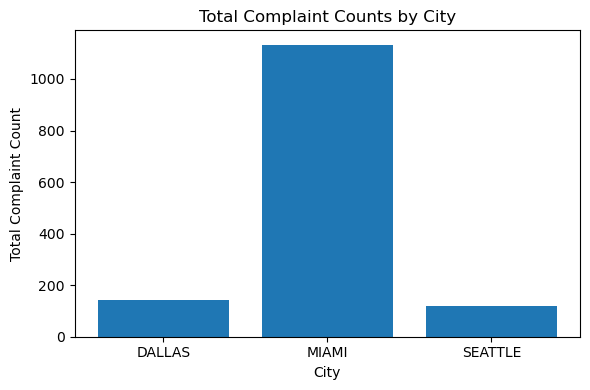

In [73]:
import matplotlib.pyplot as plt

complaints_by_city = fmcsa_complaints.groupby('city')['complaint_count'].sum().reset_index()

plt.figure(figsize=(6, 4))
plt.bar(complaints_by_city['city'], complaints_by_city['complaint_count'])

plt.xlabel('City')
plt.ylabel('Total Complaint Count')
plt.title('Total Complaint Counts by City')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

With this chart is possible to see that Miami is the city with the most complaints, by far.

## Bonus
### Fine Art

Another interesting point to be observed about the data is if a customer wants to transport Fine Art in their moving process. Filtering the data by Fine Art Transport, we find that there are only two companies in the dataframe that offer this type of service:

In [74]:
fmcsa_companies_art = fmcsa_companies.query('fine_art_transport == True')[['usdot_num', 'company_name', 'city', 'total_complaints_2023', 'carrier_type', 'fine_art_transport']]
fmcsa_companies_art.sort_values(by='total_complaints_2023', ascending=True).head(10)

,usdot_num,company_name,city,total_complaints_2023,carrier_type,fine_art_transport
21,1439080,ARTEMIS FINE ARTS INC,DALLAS,0,Interstate,True
35,1707005,UNIFIED FINE ARTS SERVICES LLC,DALLAS,0,Interstate,True


### Most Common Words
Using the customer_reviews dataframe, it is possible to count what are the most common themes mentioned in the cusotmer's review text. One way to do this is using a function to find the words manually, like *'help', 'great' and 'avoid'*

In [78]:
customer_reviews_help = customer_reviews[customer_reviews['review_text'].str.contains('help', case=False, na=False)]

len(customer_reviews_help)

2670

In [79]:
customer_reviews_great = customer_reviews[customer_reviews['review_text'].str.contains('great', case=False, na=False)]

len(customer_reviews_great)

3407

In [80]:
customer_reviews_avoid = customer_reviews[customer_reviews['review_text'].str.contains('avoid', case=False, na=False)]

len(customer_reviews_avoid)

53

Another way to do this is writing a function using `re` library to find them by frequency:

In [77]:
from collections import Counter
import re

all_text = ' '.join(customer_reviews['review_text'].dropna())
words = re.findall(r'\w+', all_text.lower())  # to lowercase
word_counts = Counter(words)

most_common_words = word_counts.most_common(70)

print(most_common_words)

[('and', 31761), ('the', 21985), ('to', 18141), ('i', 14207), ('a', 12879), ('was', 9381), ('with', 9152), ('they', 9009), ('of', 8266), ('were', 7528), ('in', 7507), ('my', 7333), ('we', 7241), ('for', 6825), ('our', 5414), ('very', 4841), ('move', 4417), ('on', 4286), ('great', 4004), ('that', 3987), ('you', 3939), ('recommend', 3840), ('it', 3781), ('time', 3757), ('he', 3692), ('is', 3642), ('them', 3483), ('moving', 3480), ('us', 3430), ('home', 3382), ('me', 3369), ('had', 3248), ('all', 3158), ('movers', 3119), ('would', 3064), ('this', 3031), ('professional', 2929), ('have', 2771), ('so', 2586), ('as', 2545), ('team', 2478), ('from', 2368), ('t', 2316), ('highly', 2266), ('not', 2196), ('an', 2185), ('are', 2163), ('will', 2122), ('experience', 2071), ('process', 2070), ('company', 2059), ('be', 2051), ('his', 2048), ('did', 2048), ('again', 2033), ('their', 2013), ('at', 1989), ('work', 1969), ('job', 1857), ('up', 1811), ('she', 1788), ('but', 1769), ('made', 1750), ('everyth

Except for the daily use words, we can identify a high frequency of the words **great, recommend, professional and efficient**, indicating good reviews.

## Conclusion

For this project, it was possible to build all ELT pipeline for Google and FMCSA data. This involved configuring the Airflow, finding errors in the DAG and fixing them, building functions to filter and load the data into the Postgres database, performing transformations in SQL and using them to create dataframes using the notebooks, and finally showing our clients the real value of all this process, using the data to help them making better decisions.